In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd drive/MyDrive/Facial Expressions/

/content/drive/MyDrive/Facial Expressions


In [12]:
import tarfile

fname = 'fer2013.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_csv('fer2013/fer2013.csv')
df.head

<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

In [15]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [16]:
label_to_text = {0:'anger' , 1: 'disgust' , 2: 'fear' , 3: 'happiness' , 4: 'sadness' , 5: 'surprise' , 6: 'neutral'}

In [17]:
np.array(df.pixels.loc[0].split(' ')).reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

In [18]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [19]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

In [20]:
img_array = np.stack(img_array,axis=0)

In [21]:
lables = df.emotion.values

In [22]:
X_train,X_test,y_train,y_test = train_test_split(img_array,lables,test_size = .1)

In [23]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((32298, 48, 48, 1), (32298,), (3589, 48, 48, 1), (3589,))

In [24]:
X_train = X_train/255
X_test = X_test/255

In [37]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),

                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),

                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),

                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1000,activation='relu'),
                                        tf.keras.layers.Dense(7,activation='softmax')
                                        ])

In [38]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics =['accuracy'])

In [39]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [40]:
file_name = 'best model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [41]:
basemodel.fit(X_train,y_train,epochs=20,validation_split=.1,callbacks=call_back)

Epoch 1/20
909/909 [==============================] - ETA: 0s - loss: 1.7977 - accuracy: 0.2585
Epoch 00001: val_accuracy improved from -inf to 0.27492, saving model to checkpoint/best model.h5
909/909 [==============================] - 15s 16ms/step - loss: 1.7977 - accuracy: 0.2585 - val_loss: 1.7363 - val_accuracy: 0.2749
Epoch 2/20
907/909 [============================>.] - ETA: 0s - loss: 1.6481 - accuracy: 0.3558
Epoch 00002: val_accuracy improved from 0.27492 to 0.37833, saving model to checkpoint/best model.h5
909/909 [==============================] - 14s 15ms/step - loss: 1.6479 - accuracy: 0.3556 - val_loss: 1.5782 - val_accuracy: 0.3783
Epoch 3/20
909/909 [==============================] - ETA: 0s - loss: 1.5267 - accuracy: 0.4144
Epoch 00003: val_accuracy improved from 0.37833 to 0.40805, saving model to checkpoint/best model.h5
909/909 [==============================] - 14s 15ms/step - loss: 1.5267 - accuracy: 0.4144 - val_loss: 1.5163 - val_accuracy: 0.4080
Epoch 4/20
90

actual label is neutral
predicted label is neutral


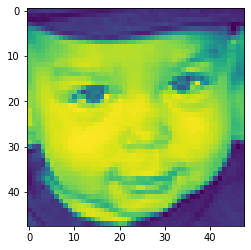

In [48]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range(40):
  print(f'actual label is {label_to_text[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(X_test[k].reshape((48,48)))
  pyplot.show()
  time.sleep(5)
  clear_output(wait=True)